Load the required packages

In [56]:
import time
import math
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import cv2
import csv

from sklearn.metrics import confusion_matrix
from datetime import timedelta
from PIL import Image
from numpy import float32
from numpy import uint8
from numpy import int64
%matplotlib inline

In [29]:
# Convolutional Layer 1.
filter_size1 = 3 
num_filters1 = 32

# Convolutional Layer 2.
filter_size2 = 3
num_filters2 = 32

# Convolutional Layer 3.
filter_size3 = 3
num_filters3 = 64

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

# Number of color channels for the images: 1 channel for gray-scale.
num_channels = 3

# image dimensions (only squares for now)
img_size = 10000
IMAGE_X_DIM = 48
IMAGE_Y_DIM = 48
# Size of image when flattened to a single dimension
img_size_flat = img_size * img_size * num_channels

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# class info
classes = ['Normals', 'Benign','Malignant']
num_classes = len(classes)

# batch size
batch_size = 32

# validation split
validation_size = .16

# how long to wait after validation loss stops improving before terminating training
early_stopping = None  # use None if you d

In [70]:
def readTrainTest():
    num_images = 151
    img_length = 50
    #read image pixel vals in
    fileName = "./data/raw_data/UPNG/mdb"
    train_mgrams = []
    test_mgrams = []

    for i in range(1,num_images):
        if i < 100:
            if i < 10:
                fname = fileName + "00" + str(i) + ".png"
            else:
                fname = fileName + "0" + str(i) + ".png"
        else:
            name = fileName + str(i) + ".png"

        im = Image.open(fname).load() 

        if i < 9:
            plt.imshow(mpimg.imread(fname))
            
        center = random.randrange(482,542)

        pixels = [im[k,j] for k in range(center-img_length, center + img_length) 
                  for j in range(center - img_length, center +img_length)]

        if i < num_images - 50:
            train_mgrams.append(pixels)
        else:
            test_mgrams.append(pixels)
   
    training_data = np.ndarray(shape=(num_images - 1 - 50,100*100), buffer=np.array(train_mgrams), dtype=float32)
    testing_data = np.ndarray(shape=(50,100*100), buffer=np.array(test_mgrams), dtype=float32)

    #read label data and convert as one hot conversion
    f=open("./data/labels.csv")
    labels = []
    for row in csv.reader(f, delimiter=' '):
        #N, B, M
        if row[3] == "N":
            #labels.append([1,0,0])
            labels.append(0)
        elif row[3] == "B":
            #labels.append([0,1,0])
            labels.append(1)
        else:
            #labels.append([0,0,1])
            labels.append(2)

    del labels[num_images:]
    training_labels = np.ndarray(shape=(num_images - 1 - 50,), buffer=np.array(labels[:num_images - 50]), dtype=int64)
    testing_labels = np.ndarray(shape=(50,), buffer=np.array(labels[num_images - 50:]), dtype=int64)
    print('No of training images ',len(train_mgrams))
    print('Training dataset pixel size',len(train_mgrams[0]))

    print('No of test set images ',len(test_mgrams))
    print('Test dataset pixel size',len(test_mgrams[0]))
    return (train_mgrams,training_data, testing_data, training_labels, testing_labels)

Loading in Mammogram data...
No of training images  100
Training dataset pixel size 10000
No of test set images  50
Test dataset pixel size 10000
Mammogram data loaded.



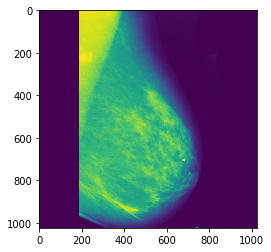

In [76]:
print("Loading in Mammogram data...")
train_mgrams,training_data,testing_data, training_labels, testing_labels=readTrainTest()
print("Mammogram data loaded.\n")

In [114]:
def plot_images(images, cls_true, cls_pred=None):
    
    if len(images) == 0:
        print("no images to show")
        return 
    else:
        random_indices = random.sample(range(len(images)), min(len(images), 9))
        
    #read image pixel vals in
    fileName = "./data/raw_data/UPNG/mdb"
    
    # Set the plot size - two plots
    plot,axes = plt.subplots(3,3,figsize = (15,10)) 
    
    for i in random_indices:
        if i < 100:
            if i < 10:
                fname = fileName + "00" + str(i) + ".png"
            else:
                fname = fileName + "0" + str(i) + ".png"
        else:
            name = fileName + str(i) + ".png"

        im = Image.open(fname).load() 
        
        plt.imshow(mpimg.imread(fname))    
    
        # Show true and predicted classes.
        if cls_true[i] ==0:
            xlabel = "Normal"
        elif cls_true[i] ==1:
            xlabel = 'Benign'
        else:
            xlabel = 'Malignant'

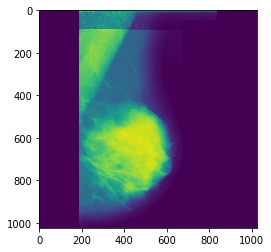

In [115]:
# Get some random images and their labels from the train set.

images, cls_true  = train_mgrams, training_labels

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

In [ ]:

def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))
